In [1]:
%load_ext autoreload
%autoreload 2
from pybaseball import statcast, pitching_stats
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from matplotlib import patches
%matplotlib inline

# use Statcast data (from 2015-2018) so we can get spin rate, etc.
train_data_dates = [('2015-04-05', '2015-10-04'),      # 2015 data
                    ('2016-04-03', '2016-10-02'),       # 2016 data
                    ('2017-04-02', '2017-10-01'),       # 2017 data
                    ('2018-03-29', '2018-10-01')]       # 2018 data

### Get the Outcome Style Data (Groundball/flyball rates, strike percentages, whiff rates, etc.)

In [23]:
# scrape the data from baseball savant
pitcher_season_stats = pitching_stats(2018)

# select the features that we want to use to categorize the pitchers... questions we want to answer:
#   - are they strike throwers?
#   - do they allow a lot of baserunners? 
#   - groundball or flyball pitcher?
#   - are they swing and miss guys (inside and outside of the zone)?
cols_to_keep = ['Name', 'Strikes', 'Pitches', 
                'K/9', 'BB/9',  'H/9', 'HR/9', #'AVG', 'WHIP', 'FIP', 'K/BB', 'HR/FB',
                'GB/FB', 'LD%', 'GB%', 
                'O-Swing%', 'Z-Swing%', 'Swing%', 
                'O-Contact%', 'Z-Contact%', 'Contact%', 
                'Zone%', 'F-Strike%', 'SwStr%']
pitcher_season_stats = pitcher_season_stats[cols_to_keep]

# keep only pitchers with at least 200 pitches in a season... try to weed out the noise, but keep short relievers
pitcher_season_stats = pitcher_season_stats[pitcher_season_stats['Pitches'] >= 200]

# compute the percentage of pitches that are strikes
pitcher_season_stats['Strike Pct'] = pitcher_season_stats['Strikes'] / pitcher_season_stats['Pitches']
pitcher_season_stats.drop(['Strikes', 'Pitches'], axis=1, inplace=True)

# use the GB/FB ratio to compute the OF flyball pct
pitcher_season_stats['Flyball%'] = (pitcher_season_stats['GB%'] / pitcher_season_stats['GB/FB'])

# drop the GB/FB ratio
pitcher_season_stats.drop(['GB/FB'], axis=1, inplace=True)

# rename the Name column so we can merge on it later... and the hit ball types to make them more readable
pitcher_season_stats.rename(columns={'Name': 'player_name',
                                     'GB%': 'Groundball%',
                                     'LD%': 'Linedrive%'}, inplace=True)

# reorder the columns
pitcher_season_stats = pitcher_season_stats[[
    'player_name', 'Strike Pct', 'K/9', 'BB/9', 'H/9', 'HR/9', 
    'Linedrive%', 'Groundball%', 'Flyball%', 
    'O-Swing%', 'Z-Swing%', 'Swing%', 
    'O-Contact%', 'Z-Contact%', 'Contact%', 
    'Zone%', 'F-Strike%', 'SwStr%', 
       ]]

print(f"Number of features: {pitcher_season_stats.shape[1]-1}")
pitcher_season_stats.head()

Number of features: 17


,player_name,Strike Pct,K/9,BB/9,H/9,HR/9,Linedrive%,Groundball%,Flyball%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%
41,Jacob deGrom,0.688979,11.16,1.91,6.30,0.41,0.219,0.464,0.315646,0.379,0.688,0.517,0.577,0.797,0.708,0.446,0.665,0.151
92,Max Scherzer,0.688806,12.24,2.08,6.12,0.94,0.181,0.343,0.476389,0.358,0.701,0.520,0.539,0.775,0.690,0.474,0.657,0.162
91,Justin Verlander,0.689816,12.20,1.56,6.56,1.18,0.195,0.291,0.510526,0.346,0.688,0.509,0.575,0.794,0.716,0.477,0.689,0.145
57,Chris Sale,0.678812,13.50,1.94,5.81,0.63,0.196,0.442,0.362295,0.364,0.628,0.480,0.545,0.765,0.672,0.441,0.676,0.158
133,Gerrit Cole,0.673319,12.40,2.88,6.42,0.85,0.213,0.360,0.428571,0.321,0.688,0.494,0.552,0.800,0.715,0.471,0.635,0.141


In [24]:
pitcher_season_stats.describe()

,Strike Pct,K/9,BB/9,H/9,HR/9,Linedrive%,Groundball%,Flyball%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%
count,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000
mean,0.633871,8.504501,3.564223,8.748462,1.213011,0.214669,0.426344,0.358927,0.306000,0.676434,0.465385,0.628849,0.854026,0.768489,0.429610,0.598056,0.107920
std,0.028543,2.144596,1.427828,2.017432,0.637048,0.039552,0.085403,0.083997,0.037487,0.043760,0.032972,0.082969,0.042066,0.051049,0.033501,0.051851,0.025566
min,0.552050,3.620000,0.340000,3.140000,0.000000,0.063000,0.163000,0.108148,0.144000,0.472000,0.357000,0.396000,0.687000,0.606000,0.325000,0.405000,0.040000
25%,0.614655,7.065000,2.625000,7.460000,0.785000,0.191500,0.366500,0.304270,0.284000,0.648000,0.444000,0.576500,0.830000,0.735000,0.408000,0.570000,0.090000
50%,0.634449,8.310000,3.340000,8.590000,1.130000,0.213000,0.430000,0.354400,0.305000,0.675000,0.464000,0.637000,0.855000,0.775000,0.432000,0.601000,0.105000
75%,0.653620,9.905000,4.285000,9.870000,1.520000,0.237000,0.478500,0.412883,0.329000,0.706000,0.486000,0.685000,0.884000,0.804000,0.451000,0.631000,0.124500
max,0.724324,16.310000,10.470000,20.700000,3.860000,0.394000,0.730000,0.605263,0.428000,0.835000,0.578000,0.857000,0.974000,0.913000,0.514000,0.753000,0.195000


### Get the Pitch-by-Pitch Data

In [25]:
# get the data from baseball savant
pitch_by_pitch_data = statcast(start_dt='2018-03-29', end_dt='2018-10-01')

# choose the columns we want to use for identifying Families
cols_to_keep = ['pitcher', 'player_name', 'p_throws', 
                'pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'release_spin_rate', 
                'pfx_x', 'pfx_z', 'plate_x', 'plate_z']
pitch_by_pitch_data = pitch_by_pitch_data[cols_to_keep]

# make sure pitcher ID's are ints
pitch_by_pitch_data['pitcher'] = pitch_by_pitch_data['pitcher'].astype(int)

pitch_by_pitch_data.head()

This is a large query, it may take a moment to complete
Completed sub-query from 2018-03-29 to 2018-04-03
Completed sub-query from 2018-04-04 to 2018-04-09
Completed sub-query from 2018-04-10 to 2018-04-15
Completed sub-query from 2018-04-16 to 2018-04-21
Completed sub-query from 2018-04-22 to 2018-04-27
Completed sub-query from 2018-04-28 to 2018-05-03
Completed sub-query from 2018-05-04 to 2018-05-09
Completed sub-query from 2018-05-10 to 2018-05-15
Completed sub-query from 2018-05-16 to 2018-05-21
Completed sub-query from 2018-05-22 to 2018-05-27
Completed sub-query from 2018-05-28 to 2018-06-02
Completed sub-query from 2018-06-03 to 2018-06-08
Completed sub-query from 2018-06-09 to 2018-06-14
Completed sub-query from 2018-06-15 to 2018-06-20
Completed sub-query from 2018-06-21 to 2018-06-26
Completed sub-query from 2018-06-27 to 2018-07-02
Completed sub-query from 2018-07-03 to 2018-07-08
Completed sub-query from 2018-07-09 to 2018-07-14
Completed sub-query from 2018-07-15 to 2018-

,pitcher,player_name,p_throws,pitch_type,release_speed,release_pos_x,release_pos_z,release_spin_rate,pfx_x,pfx_z,plate_x,plate_z
0,445276,Kenley Jansen,R,FC,92.2,-1.9690,6.2644,2629.0,0.3852,1.3383,0.6340,3.5245
1,445276,Kenley Jansen,R,FC,93.0,-1.7689,6.2976,2686.0,0.5206,1.2567,1.0881,2.4413
2,445276,Kenley Jansen,R,FC,91.6,-1.7451,6.2154,2581.0,0.6363,1.1421,-0.1730,2.4119
3,445276,Kenley Jansen,R,FF,93.1,-1.4250,6.1929,2243.0,-0.4317,1.3971,-0.4963,2.3184
4,445276,Kenley Jansen,R,FC,91.4,-1.9144,6.2641,2658.0,0.5592,1.1846,0.1766,1.9721


### Categorize Pitches as Fastball, Breaking Pitch or Off-Speed Pitch 

In [26]:
# group the various pitch types into three types (fastball=FB, breaking=BR and off-speed=OS)
fastball_pitches = ['FC', 'FF', 'FA', 'FT', 'SI']
breaking_pitches = ['CU', 'KC', 'KN', 'SC', 'SL', 'GY']
offspeed_pitches = ['CH', 'EP', 'FO', 'FS']

# pitches to drop (pitch outs, intentional balls, uncategorized)
dropped_pitches = ['AB', 'AS', 'IN', 'NP', 'PO', 'UN']

# categorize pitches
def categorize_pitches(x):
    if x in fastball_pitches:
        return 'FB'
    elif x in breaking_pitches:
        return 'BR'
    elif x in offspeed_pitches:
        return 'OS'
    else:
        return x
pitch_by_pitch_data['pitch_type'] = pitch_by_pitch_data['pitch_type'].apply(categorize_pitches)

# drop any rows with non-pitch pitches
pitch_by_pitch_data = pitch_by_pitch_data[~pitch_by_pitch_data['pitch_type'].isin(dropped_pitches)]

# drop any rows with NaN for pitch type
pitch_by_pitch_data = pitch_by_pitch_data[pd.notnull(pitch_by_pitch_data['pitch_type'])]

# print out the breakdown of categorized pitch types
pitch_counts = Counter(pitch_by_pitch_data['pitch_type'])
print(pitch_counts)
print()
pitch_by_pitch_data.head()

Counter({'FB': 433023, 'BR': 199176, 'OS': 86182})



,pitcher,player_name,p_throws,pitch_type,release_speed,release_pos_x,release_pos_z,release_spin_rate,pfx_x,pfx_z,plate_x,plate_z
0,445276,Kenley Jansen,R,FB,92.2,-1.9690,6.2644,2629.0,0.3852,1.3383,0.6340,3.5245
1,445276,Kenley Jansen,R,FB,93.0,-1.7689,6.2976,2686.0,0.5206,1.2567,1.0881,2.4413
2,445276,Kenley Jansen,R,FB,91.6,-1.7451,6.2154,2581.0,0.6363,1.1421,-0.1730,2.4119
3,445276,Kenley Jansen,R,FB,93.1,-1.4250,6.1929,2243.0,-0.4317,1.3971,-0.4963,2.3184
4,445276,Kenley Jansen,R,FB,91.4,-1.9144,6.2641,2658.0,0.5592,1.1846,0.1766,1.9721


### Compute Average Speed, Movement, Spin Rate and Location for Each Pitch Type (FB, BR and OS)

In [27]:
# build a list of pitcher IDs
pitcher_list = list(set(pitch_by_pitch_data['pitcher'].tolist()))
print(f"{len(pitcher_list)} pitchers in the data.")

# initiate a dataframe to hold the data
pitcher_pitch_avgs_df = pd.DataFrame()

# loop thru pitchers in the list and construct their personal DF
for pitcher in pitcher_list:
    
    # select pitches thrown by pitcher
    pitcher_df = pitch_by_pitch_data[pitch_by_pitch_data['pitcher'] == pitcher]
    total_num_pitches = len(pitcher_df)

    # loop thru the pitch types
    pitch_types = ['FB', 'BR', 'OS']
    pitch_type_avgs = []
    for pitch_type in pitch_types:

        # select the pitches thrown by pitcher by type
        pitcher_pitch_df = pitcher_df[pitcher_df['pitch_type'] == pitch_type]
        num_pitches = len(pitcher_pitch_df)

        # groupby player name/throws/pitch_type and compute mean of remaining features
        pitcher_pitch_df = pd.DataFrame(pitcher_pitch_df.groupby(['pitcher', 'player_name', 'p_throws', 'pitch_type']).mean())
        
        # rename columns to have pitch type in name
        pitcher_pitch_df.columns = [pitch_type + ' ' + x for x in pitcher_pitch_df.columns.tolist()]

        pitcher_pitch_df.reset_index(inplace=True, drop=False)
        
        # compute the percentage of pitches thrown that are of pitch_type
        pitcher_pitch_df[pitch_type+'%'] = num_pitches / total_num_pitches

        pitcher_pitch_df.drop('pitch_type', axis=1, inplace=True)

        pitcher_pitch_df.set_index(['pitcher', 'player_name', 'p_throws'], inplace=True)

        # append pitch type dataframe to pitcher's dataframe
        pitch_type_avgs.append(pitcher_pitch_df)

    # append pitcher's dataframe to main dataframe
    pitcher_pitch_avgs_df = pitcher_pitch_avgs_df.append(pd.concat(pitch_type_avgs, axis=1, join='inner'))

pitcher_pitch_avgs_df.reset_index(inplace=True, drop=False)

pitcher_pitch_avgs_df.head()

798 pitchers in the data.


,pitcher,player_name,p_throws,FB release_speed,FB release_pos_x,FB release_pos_z,FB release_spin_rate,FB pfx_x,FB pfx_z,FB plate_x,...,BR%,OS release_speed,OS release_pos_x,OS release_pos_z,OS release_spin_rate,OS pfx_x,OS pfx_z,OS plate_x,OS plate_z,OS%
0,622608.0,Antonio Senzatela,R,93.620961,-2.285924,5.945654,2087.743354,-0.365652,0.984344,0.351281,...,0.272906,86.635338,-2.488155,5.849395,2121.796992,-0.764528,0.745999,-0.418056,1.912417,0.087042
1,596001.0,Jakob Junis,R,91.015995,-2.317984,5.567430,2006.536682,-0.808441,0.922652,-0.213689,...,0.408034,84.741916,-2.263286,5.687574,1488.401198,-0.754883,0.410291,-0.502850,1.995101,0.058844
2,493603.0,Adam Ottavino,R,92.559733,-2.630619,5.449220,2338.377676,-0.764796,0.559525,0.195406,...,0.468135,88.233333,-2.762600,5.329200,1794.333333,-0.826567,0.332467,-1.474200,1.724000,0.002360
3,593958.0,Eduardo Rodriguez,L,91.985239,1.793006,5.653759,2210.555085,0.685681,1.007188,-0.126395,...,0.072201,87.415822,1.771342,5.703651,2074.484787,1.509818,0.425179,0.619170,1.602098,0.213143
4,452657.0,Jon Lester,L,89.987012,2.846886,5.631914,2269.320034,0.411403,1.113000,0.013421,...,0.157285,84.949826,2.824643,5.674921,1804.641115,1.164385,0.470043,0.425823,1.689951,0.092313


### convert release position x, z coordinates into an "arm slot angle" (measured from vertical)

In [28]:
pitcher_pitch_avgs_df['FB arm_angle'] = np.abs((180 / 3.14) * np.arctan(pitcher_pitch_avgs_df['FB release_pos_x'] / pitcher_pitch_avgs_df['FB release_pos_z']))
pitcher_pitch_avgs_df['BR arm_angle'] = np.abs((180 / 3.14) * np.arctan(pitcher_pitch_avgs_df['BR release_pos_x'] / pitcher_pitch_avgs_df['BR release_pos_z']))
pitcher_pitch_avgs_df['OS arm_angle'] = np.abs((180 / 3.14) * np.arctan(pitcher_pitch_avgs_df['OS release_pos_x'] / pitcher_pitch_avgs_df['OS release_pos_z']))
pitcher_pitch_avgs_df.drop(['FB release_pos_x', 'FB release_pos_z', 'BR release_pos_x', 'BR release_pos_z', 'OS release_pos_x', 'OS release_pos_z'], axis=1, inplace=True)

pitcher_pitch_avgs_df.head()

,pitcher,player_name,p_throws,FB release_speed,FB release_spin_rate,FB pfx_x,FB pfx_z,FB plate_x,FB plate_z,FB%,...,OS release_speed,OS release_spin_rate,OS pfx_x,OS pfx_z,OS plate_x,OS plate_z,OS%,FB arm_angle,BR arm_angle,OS arm_angle
0,622608.0,Antonio Senzatela,R,93.620961,2087.743354,-0.365652,0.984344,0.351281,2.473822,0.640052,...,86.635338,2121.796992,-0.764528,0.745999,-0.418056,1.912417,0.087042,21.040905,21.020051,23.055116
1,596001.0,Jakob Junis,R,91.015995,2006.536682,-0.808441,0.922652,-0.213689,2.430530,0.533122,...,84.741916,1488.401198,-0.754883,0.410291,-0.502850,1.995101,0.058844,22.615733,22.421867,21.710353
2,493603.0,Adam Ottavino,R,92.559733,2338.377676,-0.764796,0.559525,0.195406,2.570715,0.529504,...,88.233333,1794.333333,-0.826567,0.332467,-1.474200,1.724000,0.002360,25.782068,29.506140,27.415637
3,593958.0,Eduardo Rodriguez,L,91.985239,2210.555085,0.685681,1.007188,-0.126395,2.478752,0.714656,...,87.415822,2074.484787,1.509818,0.425179,0.619170,1.602098,0.213143,17.604580,17.450154,17.261602
4,452657.0,Jon Lester,L,89.987012,2269.320034,0.411403,1.113000,0.013421,2.349504,0.750402,...,84.949826,1804.641115,1.164385,0.470043,0.425823,1.689951,0.092313,26.829823,26.331217,26.474852


### Compute the Percent Difference Between OS and FB Speeds

In [29]:
pitcher_pitch_avgs_df['OS_FB_Diff'] = (pitcher_pitch_avgs_df['OS release_speed'] - pitcher_pitch_avgs_df['FB release_speed']) / (pitcher_pitch_avgs_df['FB release_speed'])

print(pitcher_pitch_avgs_df.columns.tolist())
pitcher_pitch_avgs_df.head()

['pitcher', 'player_name', 'p_throws', 'FB release_speed', 'FB release_spin_rate', 'FB pfx_x', 'FB pfx_z', 'FB plate_x', 'FB plate_z', 'FB%', 'BR release_speed', 'BR release_spin_rate', 'BR pfx_x', 'BR pfx_z', 'BR plate_x', 'BR plate_z', 'BR%', 'OS release_speed', 'OS release_spin_rate', 'OS pfx_x', 'OS pfx_z', 'OS plate_x', 'OS plate_z', 'OS%', 'FB arm_angle', 'BR arm_angle', 'OS arm_angle', 'OS_FB_Diff']


,pitcher,player_name,p_throws,FB release_speed,FB release_spin_rate,FB pfx_x,FB pfx_z,FB plate_x,FB plate_z,FB%,...,OS release_spin_rate,OS pfx_x,OS pfx_z,OS plate_x,OS plate_z,OS%,FB arm_angle,BR arm_angle,OS arm_angle,OS_FB_Diff
0,622608.0,Antonio Senzatela,R,93.620961,2087.743354,-0.365652,0.984344,0.351281,2.473822,0.640052,...,2121.796992,-0.764528,0.745999,-0.418056,1.912417,0.087042,21.040905,21.020051,23.055116,-0.074616
1,596001.0,Jakob Junis,R,91.015995,2006.536682,-0.808441,0.922652,-0.213689,2.430530,0.533122,...,1488.401198,-0.754883,0.410291,-0.502850,1.995101,0.058844,22.615733,22.421867,21.710353,-0.068934
2,493603.0,Adam Ottavino,R,92.559733,2338.377676,-0.764796,0.559525,0.195406,2.570715,0.529504,...,1794.333333,-0.826567,0.332467,-1.474200,1.724000,0.002360,25.782068,29.506140,27.415637,-0.046742
3,593958.0,Eduardo Rodriguez,L,91.985239,2210.555085,0.685681,1.007188,-0.126395,2.478752,0.714656,...,2074.484787,1.509818,0.425179,0.619170,1.602098,0.213143,17.604580,17.450154,17.261602,-0.049676
4,452657.0,Jon Lester,L,89.987012,2269.320034,0.411403,1.113000,0.013421,2.349504,0.750402,...,1804.641115,1.164385,0.470043,0.425823,1.689951,0.092313,26.829823,26.331217,26.474852,-0.055977


### Merge the Outcome Style Data with the Pitch Characteristic Data

In [30]:
pitcher_data = pd.merge(pitcher_pitch_avgs_df, pitcher_season_stats, how='inner', on='player_name')
pitcher_data.dropna(inplace=True)
print(f"Shape of the final training data: {pitcher_data.shape}")
pitcher_data.head()

Shape of the final training data: (535, 45)


,pitcher,player_name,p_throws,FB release_speed,FB release_spin_rate,FB pfx_x,FB pfx_z,FB plate_x,FB plate_z,FB%,...,Flyball%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%
0,622608.0,Antonio Senzatela,R,93.620961,2087.743354,-0.365652,0.984344,0.351281,2.473822,0.640052,...,0.326056,0.247,0.665,0.427,0.670,0.868,0.803,0.431,0.613,0.084
1,596001.0,Jakob Junis,R,91.015995,2006.536682,-0.808441,0.922652,-0.213689,2.430530,0.533122,...,0.371681,0.318,0.640,0.464,0.617,0.903,0.796,0.454,0.627,0.095
2,493603.0,Adam Ottavino,R,92.559733,2338.377676,-0.764796,0.559525,0.195406,2.570715,0.529504,...,0.383929,0.261,0.556,0.391,0.495,0.804,0.688,0.440,0.602,0.122
3,593958.0,Eduardo Rodriguez,L,91.985239,2210.555085,0.685681,1.007188,-0.126395,2.478752,0.714656,...,0.411702,0.316,0.710,0.474,0.629,0.857,0.766,0.400,0.615,0.111
4,452657.0,Jon Lester,L,89.987012,2269.320034,0.411403,1.113000,0.013421,2.349504,0.750402,...,0.362500,0.272,0.680,0.438,0.678,0.879,0.805,0.406,0.574,0.085


### Split Into Two Groups: Lefties and Righties

In [31]:
lh_pitcher_data = pitcher_data[pitcher_data['p_throws'] == 'L']
print(f"Number of LH pitchers: {lh_pitcher_data.shape[0]}")

rh_pitcher_data = pitcher_data[pitcher_data['p_throws'] == 'R']
print(f"Number of RH pitchers: {rh_pitcher_data.shape[0]}")

Number of LH pitchers: 135
Number of RH pitchers: 400


## Rescaling, PCA and Clustering 

### Helper functions: Rescale the Data, Perform PCA and Find Number of Dimensions to Explain 98% of the Variance, Plot the clusters, etc.

In [32]:
# custom scatter plot function which allows for markers to take a list
def mscatter(x,y, ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    ax = ax or plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

# perform k-means clustering and use the Gap Statistic to find optimal k
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):

            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)

            # Fit to it
            km = KMeans(k, n_jobs=-1)
            km.fit(randomReference)

            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)

        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap

        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal



def perform_pca_clustering(data):

    data.reset_index(inplace=True, drop=True)

    # keep pitcher ID and name
    data_ID_name = data[['pitcher', 'player_name']]

    # data for clustering
    data_clustering = data.drop(['pitcher', 'player_name', 'p_throws'], axis=1)
    print(f"Number of original dimensions: {data_clustering.shape[1]}")

    # rescale 
    scaler = MinMaxScaler()
    data_clustering_scaled = pd.DataFrame(scaler.fit_transform(data_clustering))

    # find the minimal number of dimensions that captures 98% of the variance
    # fitting the PCA algorithm with our Data
    pca = PCA().fit(data_clustering_scaled)

    # the cumulative explained variance
    exp_var_ratio = list(np.cumsum(pca.explained_variance_ratio_))

    # use the number of dimensions that get us to 98% explained variance
    exp_var_threshold = 0.98
    for i, ev in enumerate(exp_var_ratio):
        if ev > exp_var_threshold:
            num_components = i
            break
        else:
            num_components = len(data_clustering_scaled.columns)

    print(f"{num_components} are required to explain 98% of the variance.")
    
    # perform PCA with computed number of dimensions
    pca = PCA(n_components=num_components)
    data_clustering_pca = pd.DataFrame(pca.fit_transform(data_clustering_scaled))

    # find the optimal k
    k, _ = optimalK(data_clustering_pca)
    print(f"Optimal k: {k}")

    # perform K-Means clustering with computed number of clusters
    kmeans = KMeans(n_clusters=k)
    kmeans.fit_transform(data_clustering_pca)
    labels = pd.DataFrame(kmeans.labels_)
    labels.rename(columns={0: 'Cluster_Number'}, inplace=True)

    # put the original data back together with a new column for the cluster number label
    pitchers_clusters = pd.concat([data_ID_name, labels, data_clustering], axis=1, join='inner')
    
    # re-do the analysis for visualization purposes
    # perform PCA with only 2dimensions
    pca = PCA(n_components=2)
    data_clustering_pca = pd.DataFrame(pca.fit_transform(data_clustering_scaled))

    kmeans = KMeans(n_clusters=k).fit(data_clustering_pca)

    labels = kmeans.labels_
    # map cluster number to marker 
    marker_map = {0: 'o', 1: 'v', 2: '^', 3: '>', 4: '<', 5: '8', 6: 's', 7: 'p',
                  8: 'P', 9: '*', 10: 'D', 11: 'X', 12: 'h', 13: 'H'}
    labels = [marker_map[x] for x in labels]

    data_clustering_pca['cluster_number'] = kmeans.predict(data_clustering_pca)

    data_clustering_pca['cluster_number'] = data_clustering_pca['cluster_number'].apply(lambda x: marker_map[x])

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax2 = mscatter(data_clustering_pca.iloc[:, 0], data_clustering_pca.iloc[:, 1], ax=ax, m=labels, c=kmeans.labels_, s=80)
    
    return k, pitchers_clusters, ax2

### Analysis for Lefties

Number of original dimensions: 42
27 are required to explain 98% of the variance.
Optimal k: 13


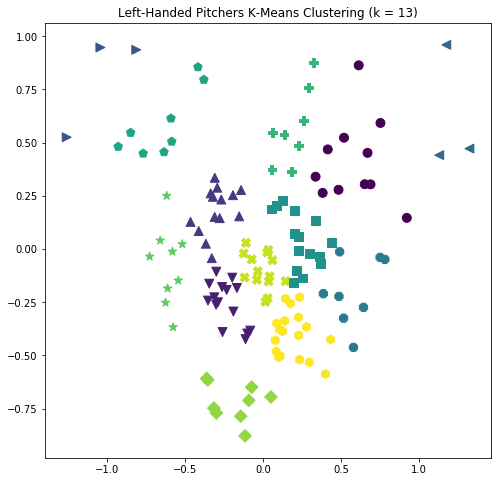

In [33]:
lh_k, lh_pitchers_clusters, ax = perform_pca_clustering(lh_pitcher_data)
plt.title(f"Left-Handed Pitchers K-Means Clustering (k = {lh_k})")
plt.show()

In [34]:
lh_pitchers_clusters.head()

,pitcher,player_name,Cluster_Number,FB release_speed,FB release_spin_rate,FB pfx_x,FB pfx_z,FB plate_x,FB plate_z,FB%,...,Flyball%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%
0,593958.0,Eduardo Rodriguez,3,91.985239,2210.555085,0.685681,1.007188,-0.126395,2.478752,0.714656,...,0.411702,0.316,0.710,0.474,0.629,0.857,0.766,0.400,0.615,0.111
1,452657.0,Jon Lester,12,89.987012,2269.320034,0.411403,1.113000,0.013421,2.349504,0.750402,...,0.362500,0.272,0.680,0.438,0.678,0.879,0.805,0.406,0.574,0.085
2,593974.0,Wandy Peralta,5,95.501655,2097.832151,1.088163,1.060323,0.114226,2.330265,0.487889,...,0.271751,0.310,0.676,0.468,0.612,0.886,0.783,0.434,0.582,0.102
3,606273.0,Roenis Elias,4,94.126432,2433.367841,0.891914,1.326460,-0.085540,2.461938,0.547648,...,0.417073,0.286,0.722,0.472,0.699,0.855,0.801,0.426,0.514,0.094
4,608331.0,Max Fried,4,93.022985,2037.889552,0.382801,1.014229,-0.093833,2.738846,0.586690,...,0.203162,0.277,0.626,0.420,0.495,0.823,0.696,0.412,0.578,0.128


### Analysis for Righties 

Number of original dimensions: 42
28 are required to explain 98% of the variance.
Optimal k: 14


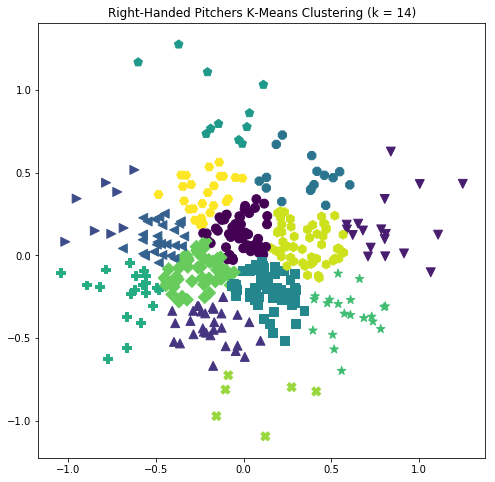

In [35]:
rh_k, rh_pitchers_clusters, ax = perform_pca_clustering(rh_pitcher_data)
plt.title(f"Right-Handed Pitchers K-Means Clustering (k = {rh_k})")
plt.show()

In [36]:
rh_pitchers_clusters.head()

,pitcher,player_name,Cluster_Number,FB release_speed,FB release_spin_rate,FB pfx_x,FB pfx_z,FB plate_x,FB plate_z,FB%,...,Flyball%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%
0,622608.0,Antonio Senzatela,8,93.620961,2087.743354,-0.365652,0.984344,0.351281,2.473822,0.640052,...,0.326056,0.247,0.665,0.427,0.670,0.868,0.803,0.431,0.613,0.084
1,596001.0,Jakob Junis,6,91.015995,2006.536682,-0.808441,0.922652,-0.213689,2.430530,0.533122,...,0.371681,0.318,0.640,0.464,0.617,0.903,0.796,0.454,0.627,0.095
2,493603.0,Adam Ottavino,4,92.559733,2338.377676,-0.764796,0.559525,0.195406,2.570715,0.529504,...,0.383929,0.261,0.556,0.391,0.495,0.804,0.688,0.440,0.602,0.122
3,444468.0,Hector Rondon,1,97.168473,2048.151067,-0.747914,1.210215,0.044503,2.456533,0.617021,...,0.326429,0.296,0.703,0.478,0.528,0.825,0.723,0.448,0.608,0.132
4,501817.0,Tony Barnette,1,91.802069,2511.755172,-0.199828,1.130500,-0.126271,2.438061,0.716049,...,0.300585,0.332,0.615,0.459,0.568,0.875,0.753,0.449,0.712,0.114


## Qualitative Analysis of the Clusters

### Left-Handed Pitchers

In [37]:
def get_group_box_plot(df, k, feat_name):
    feat_list = []
    for i in range(k):
        k_df = df[df['Cluster_Number'] == i]
        feat = k_df[feat_name].tolist()
        feat_list.append(feat)
    feat_avg = df[feat_name].mean()
    feat_std = df[feat_name].std()

    plt.boxplot(feat_list)
    plt.plot([1, k+1], [feat_avg+feat_std, feat_avg+feat_std], 'k--')
    plt.plot([1, k+1], [feat_avg, feat_avg], 'k--')
    plt.plot([1, k+1], [feat_avg-feat_std, feat_avg-feat_std], 'k--')
    plt.title(feat_name)
    plt.xlabel('Cluster Number')
    plt.show()

#### Feature Distributions for Each Cluster

The horizontal dashed lines represent the mean for all left-handers (and the 1 sigma bounds)

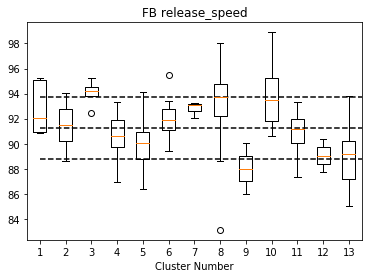

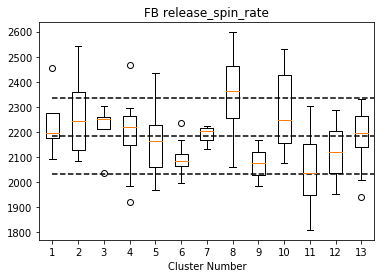

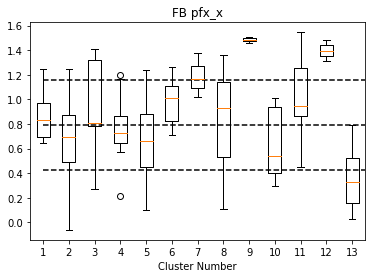

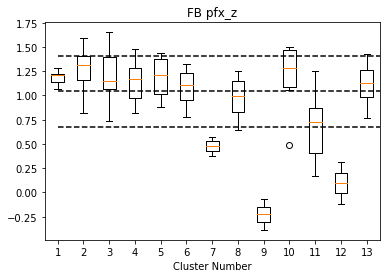

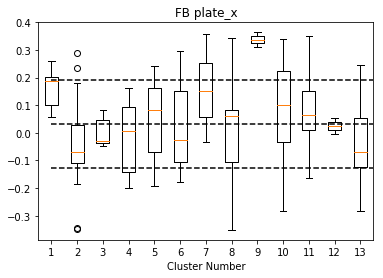

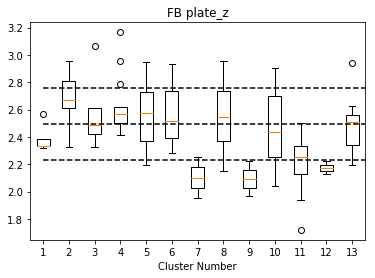

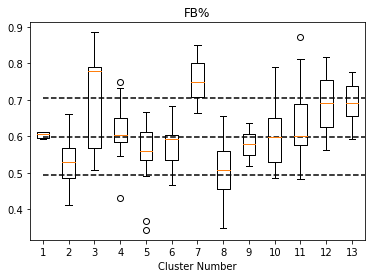

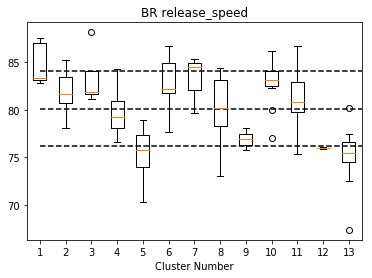

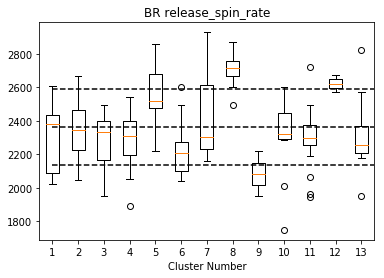

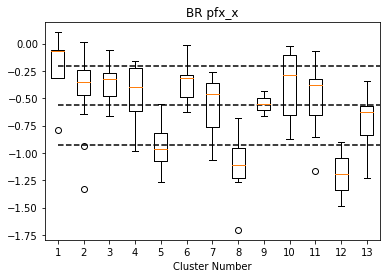

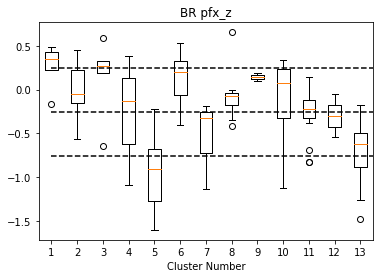

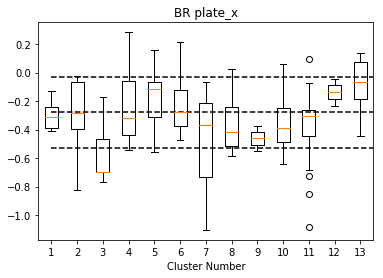

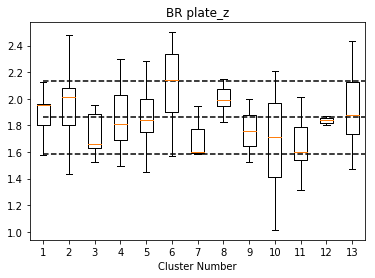

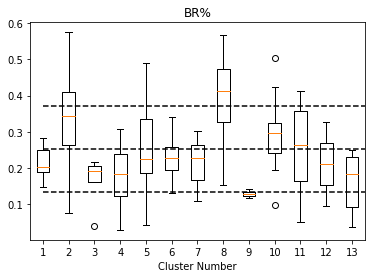

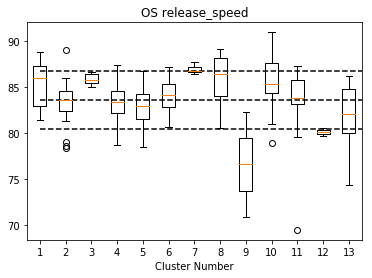

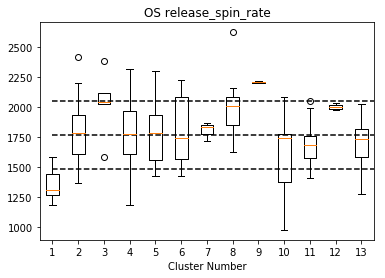

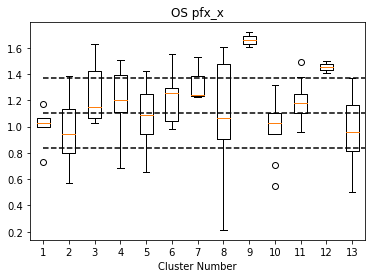

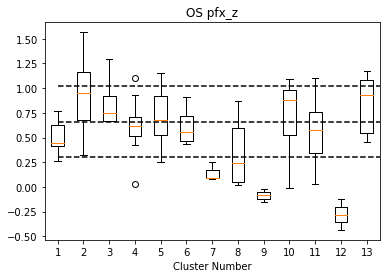

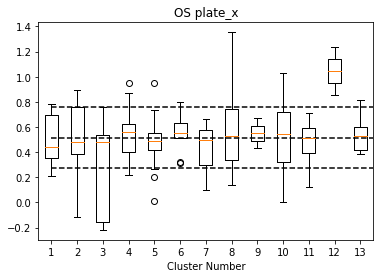

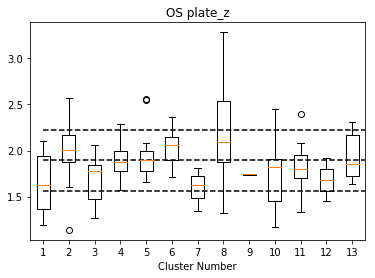

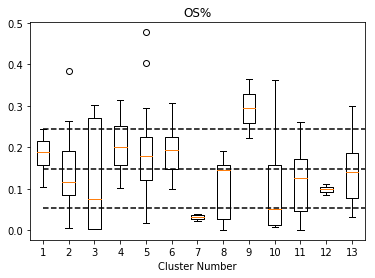

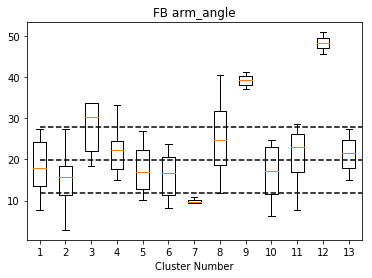

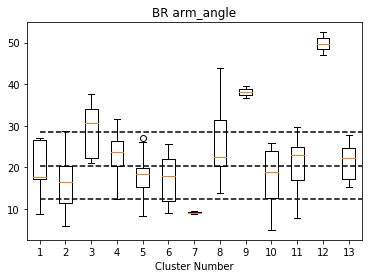

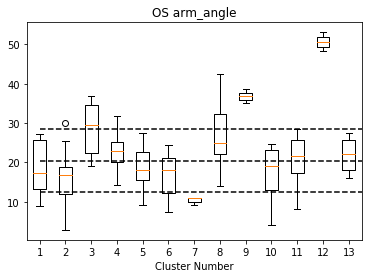

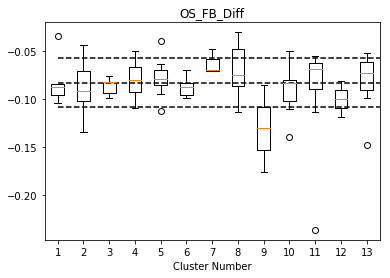

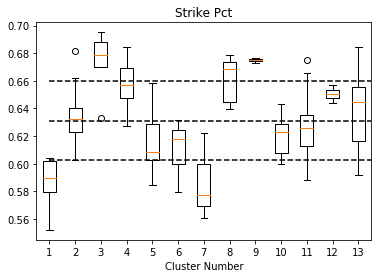

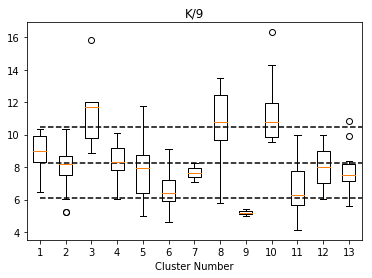

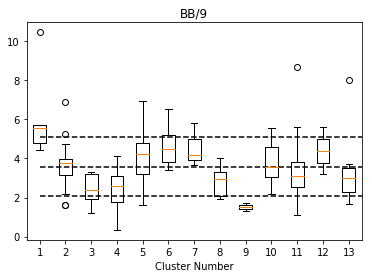

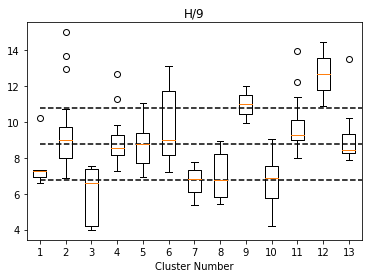

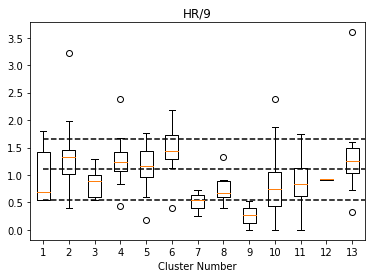

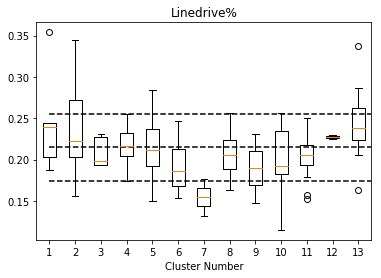

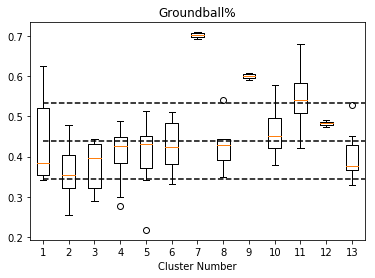

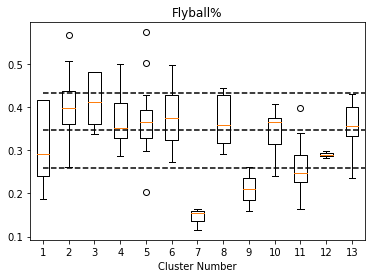

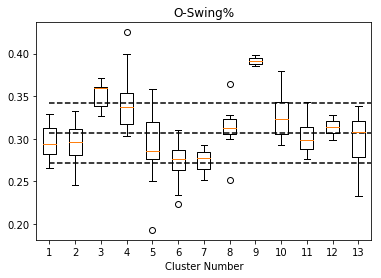

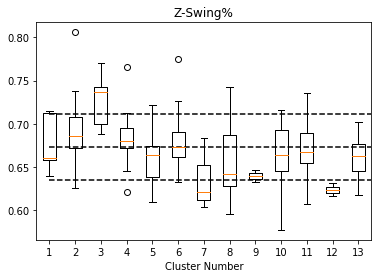

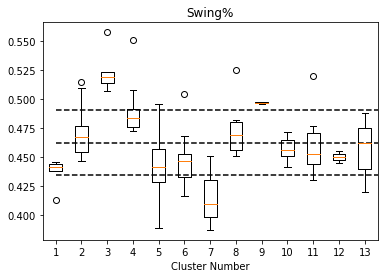

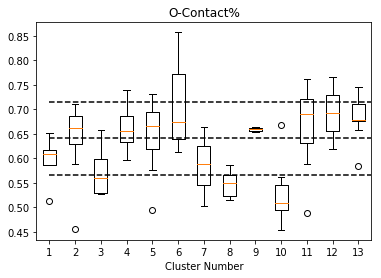

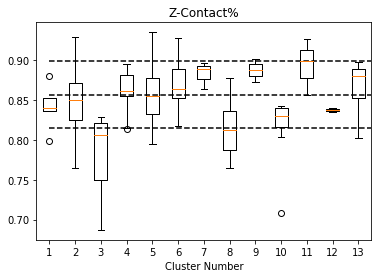

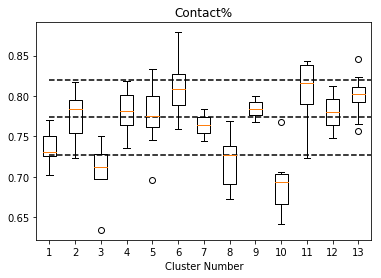

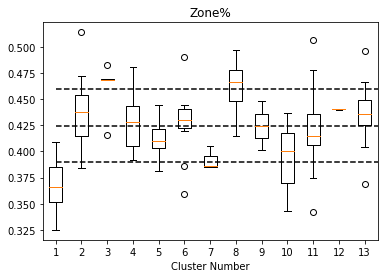

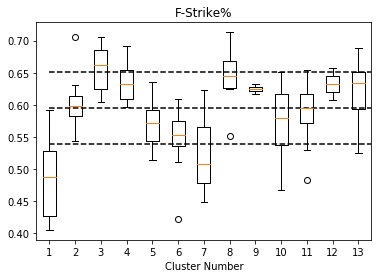

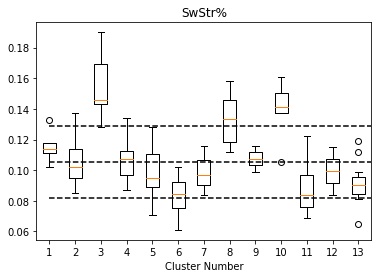

In [38]:
for col in lh_pitchers_clusters.columns.tolist()[3:]:
    get_group_box_plot(lh_pitchers_clusters, lh_k, col)

#### Looks like Cluster 12 is Made up of Hard-Throwing Swing & Miss guys

In [39]:
lh_pitchers_clusters[lh_pitchers_clusters['Cluster_Number'] == 11]

,pitcher,player_name,Cluster_Number,FB release_speed,FB release_spin_rate,FB pfx_x,FB pfx_z,FB plate_x,FB plate_z,FB%,...,Flyball%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%
25,643354.0,Donnie Hart,11,87.746479,1952.578199,1.481232,-0.117439,0.054777,2.219929,0.562005,...,0.297484,0.299,0.631,0.445,0.766,0.840,0.812,0.440,0.657,0.084
40,571901.0,Aaron Loup,11,90.370447,2286.103270,1.310997,0.309971,-0.004567,2.128441,0.818565,...,0.282759,0.328,0.616,0.455,0.618,0.835,0.748,0.441,0.607,0.115


### Right-Handed Pitchers

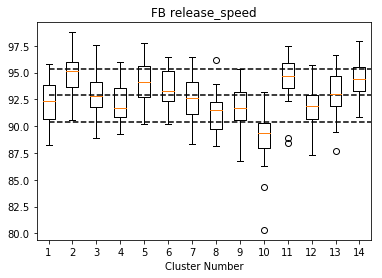

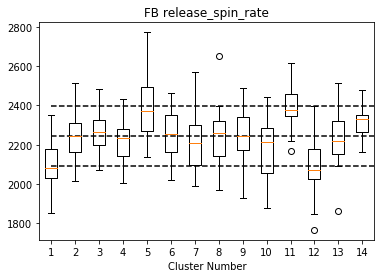

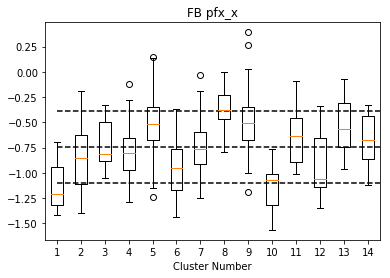

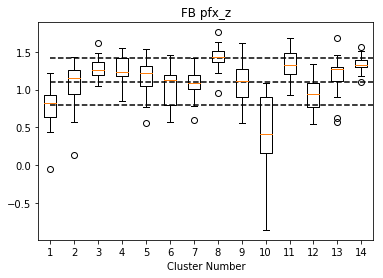

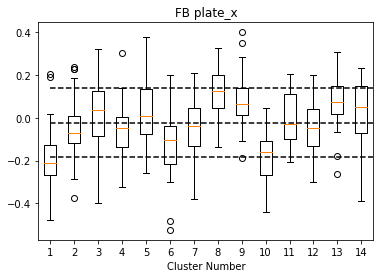

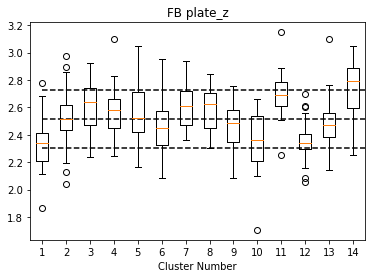

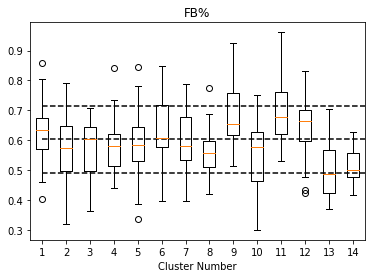

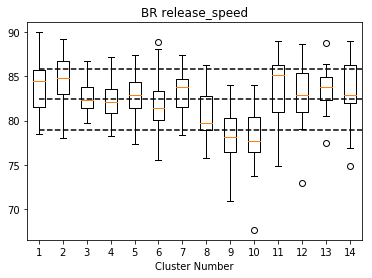

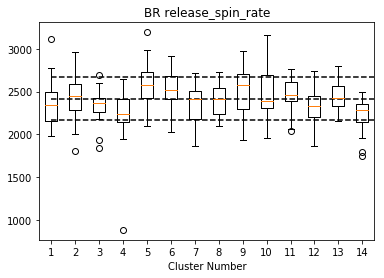

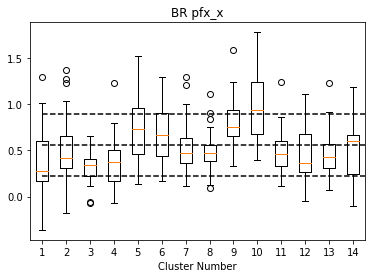

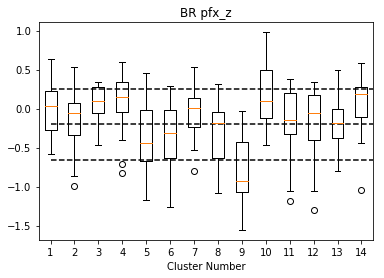

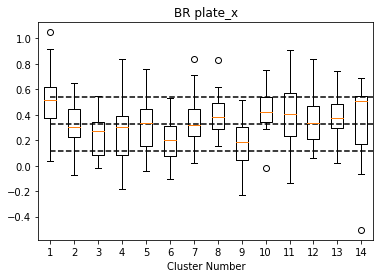

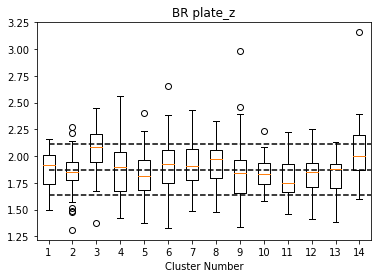

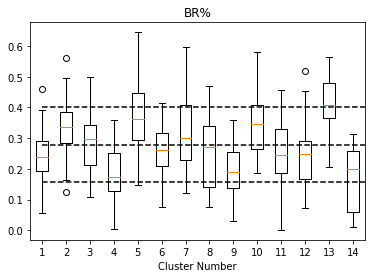

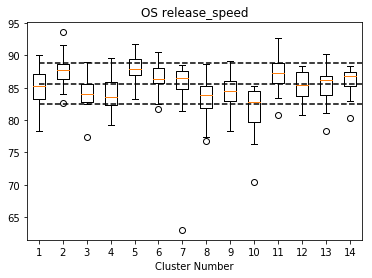

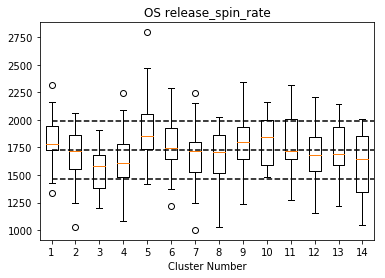

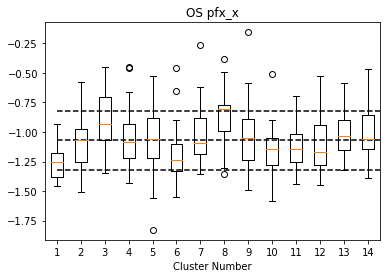

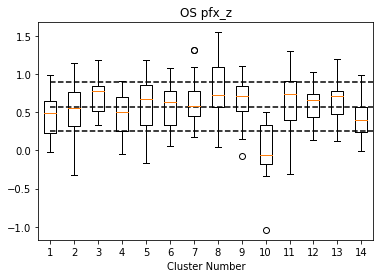

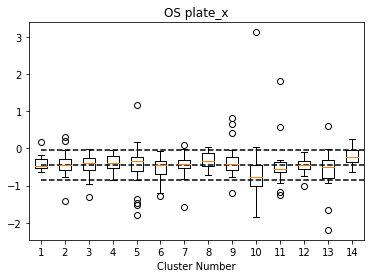

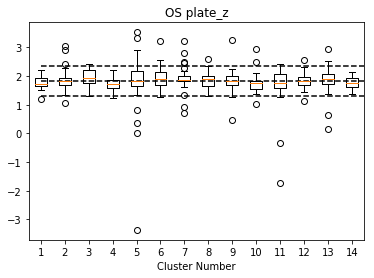

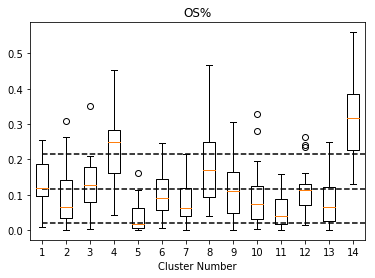

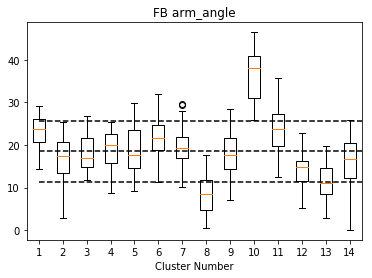

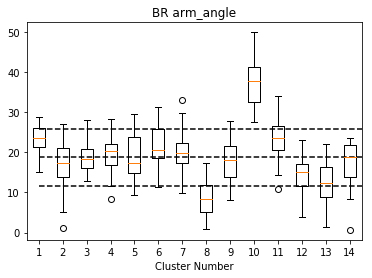

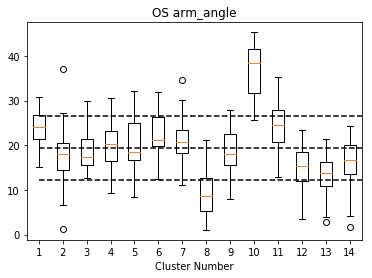

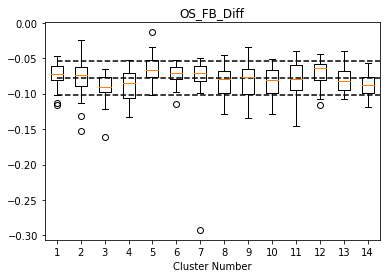

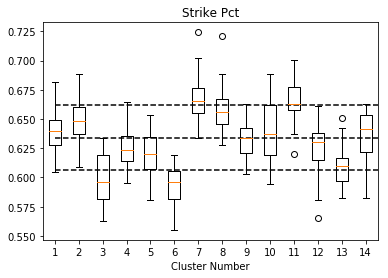

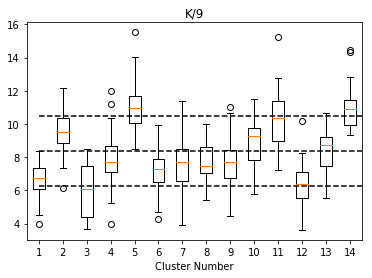

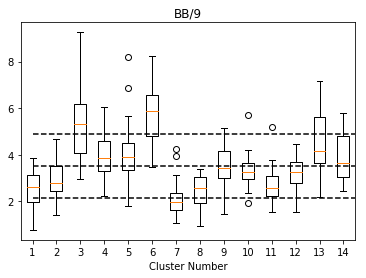

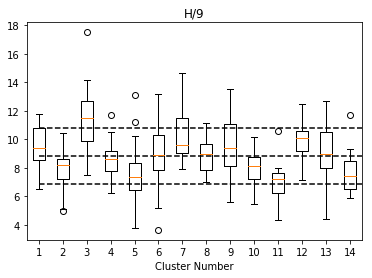

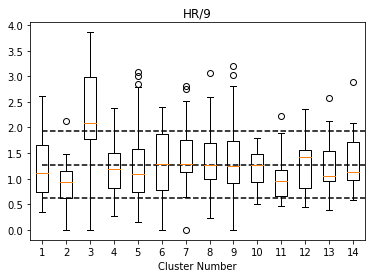

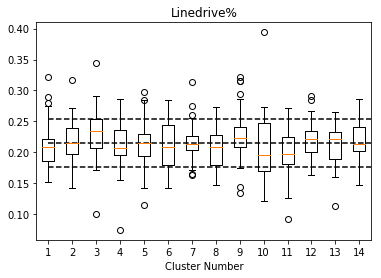

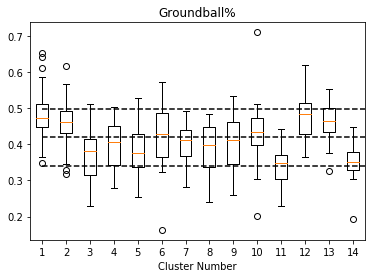

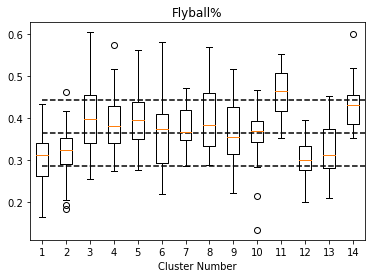

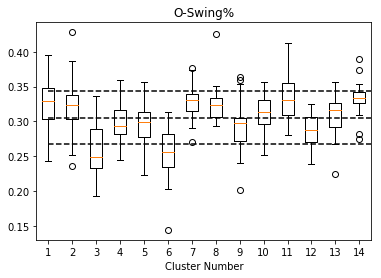

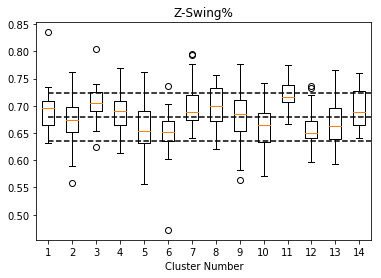

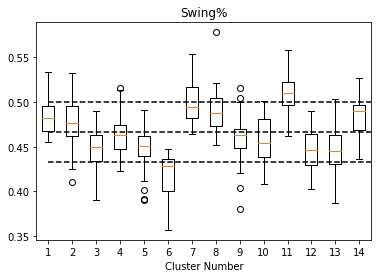

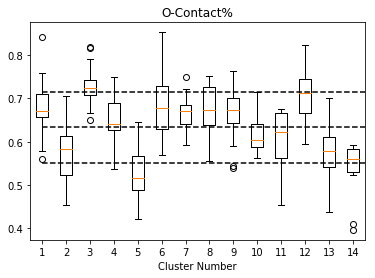

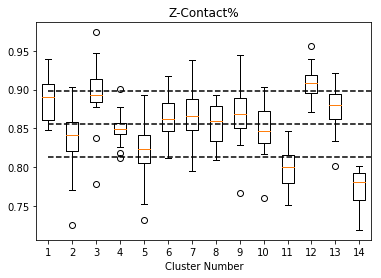

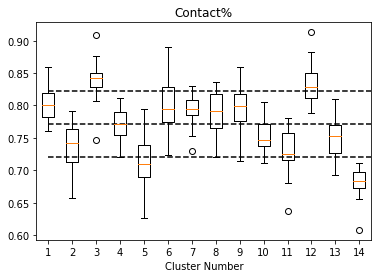

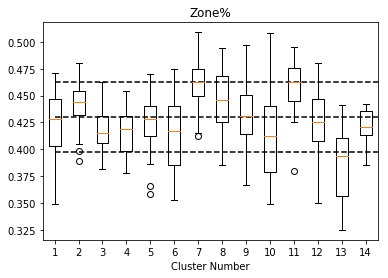

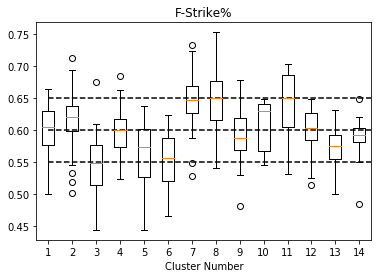

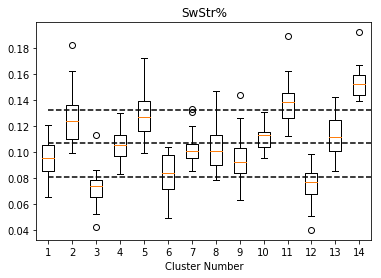

In [40]:
for col in rh_pitchers_clusters.columns.tolist()[3:]:
    get_group_box_plot(rh_pitchers_clusters, rh_k, col)

In [43]:
rh_pitchers_clusters[rh_pitchers_clusters['Cluster_Number'] == 10]

,pitcher,player_name,Cluster_Number,FB release_speed,FB release_spin_rate,FB pfx_x,FB pfx_z,FB plate_x,FB plate_z,FB%,...,Flyball%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%
35,434378.0,Justin Verlander,10,94.994513,2617.839640,-0.910209,1.677226,0.143476,2.765317,0.617587,...,0.510526,0.346,0.688,0.509,0.575,0.794,0.716,0.477,0.689,0.145
45,643338.0,Chad Green,10,96.121237,2444.303786,-0.385125,1.497825,0.015290,2.740816,0.865707,...,0.455072,0.315,0.741,0.521,0.675,0.791,0.755,0.484,0.695,0.128
62,571710.0,Mychal Givens,10,95.075732,2371.800209,-0.677739,1.014125,-0.109511,2.507334,0.767871,...,0.392473,0.288,0.716,0.500,0.669,0.812,0.771,0.495,0.558,0.115
63,543037.0,Gerrit Cole,10,96.504248,2372.466776,-0.967238,1.401775,0.002229,2.830159,0.563709,...,0.428571,0.321,0.688,0.494,0.552,0.800,0.715,0.471,0.635,0.141
68,518489.0,Ryan Brasier,10,96.842434,2344.460526,-0.566195,1.300972,0.205040,2.787296,0.625514,...,0.402000,0.413,0.737,0.558,0.559,0.825,0.716,0.447,0.702,0.158
97,608716.0,Drew Steckenrider,10,94.620862,2354.206349,-0.772391,1.581389,-0.205218,2.622744,0.764298,...,0.423750,0.288,0.721,0.485,0.672,0.816,0.769,0.454,0.610,0.112
137,543339.0,Daniel Hudson,10,95.337275,2437.326478,-0.582436,1.264467,-0.063470,2.693246,0.544056,...,0.357692,0.281,0.718,0.497,0.581,0.805,0.741,0.494,0.655,0.129
149,453286.0,Max Scherzer,10,93.439933,2476.660259,-0.735003,1.076379,0.088006,2.682863,0.597989,...,0.476389,0.358,0.701,0.520,0.539,0.775,0.690,0.474,0.657,0.162
152,621242.0,Edwin Diaz,10,97.256148,2340.478142,-0.891500,1.293388,-0.208201,2.658960,0.625107,...,0.352381,0.364,0.708,0.519,0.453,0.751,0.637,0.451,0.675,0.189
155,641729.0,Joe Jimenez,10,95.515694,2552.399481,-0.885772,1.421576,-0.099487,2.594891,0.672188,...,0.456410,0.308,0.711,0.481,0.602,0.789,0.721,0.431,0.532,0.134
